In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchsummary import summary

import time
import copy
import os

/Users/venkatakrishnanvk/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# torch.manual_seed(10)

In [3]:
data_dir = 'data/grid2'
mask_dir = 'data/output'

In [4]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.CenterCrop((448,448)),
        # transforms.Resize((512,512)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Train2': transforms.Compose([
        transforms.CenterCrop((448,448)),
        # transforms.Resize((512,512)),
        transforms.RandomVerticalFlip(p=1),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Test1': transforms.Compose([
        transforms.CenterCrop((448,448)),
        # transforms.Resize((512,512)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'Test2': transforms.Compose([
        transforms.CenterCrop((448,448)),
        # transforms.Resize((512,512)),
        transforms.RandomVerticalFlip(p=1),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
}
mask_transforms = {
    'Train': transforms.Compose([
        transforms.CenterCrop((448,448)),
        # transforms.Resize((512,512)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0), (0.63))
    ]),
    'Train2': transforms.Compose([
        transforms.CenterCrop((448,448)),
        # transforms.Resize((512,512)),
        transforms.RandomVerticalFlip(p=1),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0), (0.63))
    ]),
    'Test1': transforms.Compose([
        transforms.CenterCrop((448,448)),
        # transforms.Resize((512,512)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0), (0.63))
    ]),
    'Test2': transforms.Compose([
        transforms.CenterCrop((448,448)),
        # transforms.Resize((512,512)),
        transforms.RandomVerticalFlip(p=1),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0), (0.63))
    ])
}

In [5]:
class CFD_Dataset(Dataset):
    def __init__(self, data_dir, mask_dir, train = True, transform = None, transform2 = None, mask_transform = None, mask_transform2 = None) -> None:
        super(CFD_Dataset, self).__init__()
        self.imgs = []
        self.transform = transform
        if train:
            for file1 in os.scandir(data_dir+'/Train'):
                if file1.name!='.DS_Store':
                    name = file1.name[:-4]
                    file2 = mask_dir+'/Train/'+file1.name[:-4]+'_output.png'
                    AoA = name[-1]
                    AoA = int(AoA)
                    rotation = transforms.RandomRotation((AoA,AoA))
                    if self.transform is not None:
                        self.imgs.append((self.transform(rotation(Image.open(file1.path).convert('RGB'))),30*mask_transform(rotation(Image.open(file2))), -AoA))
                        for i in range(len(transform2)):
                            self.imgs.append((transform2[i](rotation(Image.open(file1.path).convert('RGB'))),30*mask_transform2[i](rotation(Image.open(file2))), AoA))
                    else:
                        self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2), AoA))
        else:
            for file1 in os.scandir(data_dir+'/Test'):
                if file1.name!='.DS_Store':
                    file2 = mask_dir+'/Test/'+file1.name[:-4]+'_output.png'
                    name = file1.name[:-4]
                    AoA = name[-1]
                    AoA = int(AoA)
                    rotation = transforms.RandomRotation((AoA,AoA))
                    if self.transform is not None:
                        self.imgs.append((self.transform[0](rotation(Image.open(file1.path).convert('RGB'))),30*mask_transform[0](rotation(Image.open(file2))), -AoA))
                        self.imgs.append((self.transform[1](rotation(Image.open(file1.path).convert('RGB'))),30*mask_transform[1](rotation(Image.open(file2))), AoA))
                    else:
                        self.imgs.append((Image.open(file1.path).convert('RGB'),Image.open(file2), AoA))
                        # if self.imgs[-1][0].shape[0] == 1:
                        #     self.imgs[-1] = (self.imgs[-1][0].repeat(3,1,1), self.imgs[-1][1])
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index]

In [6]:
train_data = CFD_Dataset(data_dir, mask_dir, train = True, transform=data_transforms['Train'], transform2=[data_transforms['Train2']], mask_transform=mask_transforms['Train'], mask_transform2=[mask_transforms['Train2']])
val_data = CFD_Dataset(data_dir, mask_dir, train = False, transform=[data_transforms['Test1'], data_transforms['Test2']], mask_transform=[mask_transforms['Test1'], mask_transforms['Test2']])

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size = 1,
    shuffle = True,
)
val_loader = DataLoader(
    val_data,
    batch_size = 1,
    shuffle = True,
)

In [8]:
def image_show(grid, cfd, AoA, pred = None):
    # grid = grid*4 - 1
    # cfd = cfd*4 - 1
    plt.figure(figsize=(20,10))
    if pred is not None:
        plt.subplot(1,3,1)
        plt.title(f'Geometry (AoA = {AoA}$\degree$)')
        plt.imshow(grid.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title(f'True CFD simulation (AoA = {AoA}$\degree$)')
        plt.imshow(cfd.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,3)
        plt.title(f'Predicted CFD simulation (AoA = {AoA}$\degree$)')
        plt.imshow(pred.detach().numpy().transpose((1,2,0)), cmap='gray')
    else:
        plt.subplot(1,3,1)
        plt.title(f'Geometry (AoA = {AoA}$\degree$)')
        plt.imshow(grid.numpy().transpose((1,2,0)), cmap='gray')
        plt.subplot(1,3,2)
        plt.title(f'CFD simulation (AoA = {AoA}$\degree$)')
        plt.imshow(cfd.numpy().transpose((1,2,0)), cmap='gray')

tensor(0.9922)
tensor(-1.)
tensor(19.7946)
tensor(0.)


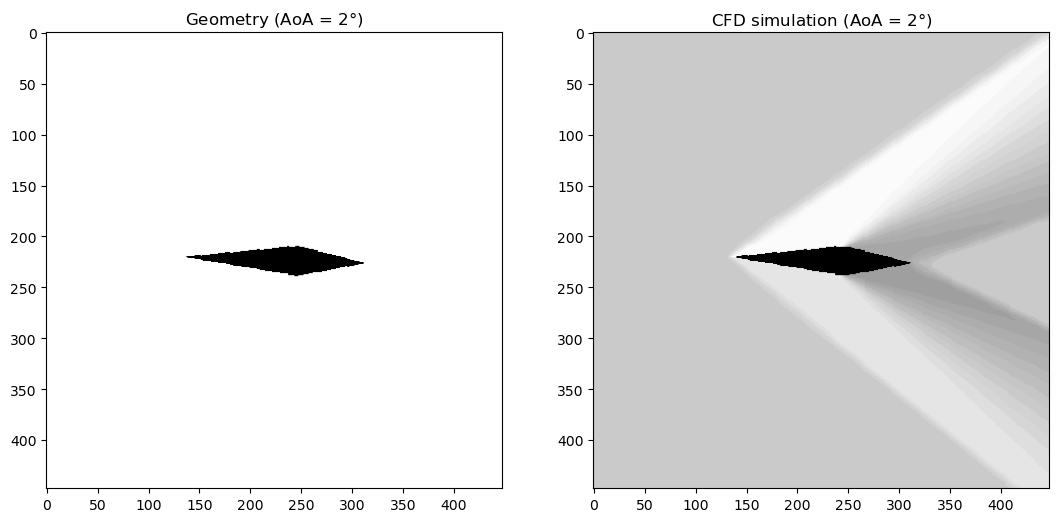

In [9]:
dataiter = iter(train_loader)
image, mask, AoA = next(dataiter)
print(torch.max(image))
print(torch.min(image))
print(torch.max(mask))
print(torch.min(mask))
index = 0
image_show(image[index], mask[index], AoA[index])

In [10]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [11]:
class DenseBlock(nn.Sequential):
    def __init__(self, channels: int, output_channels: int) -> None:
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels+0*output_channels, output_channels, 9, 1, 'same')
        self.norm1 = nn.BatchNorm2d(output_channels)
        self.conv2 = nn.Conv2d(channels+1*output_channels, output_channels, 9, 1, 'same')
        self.norm2 = nn.BatchNorm2d(output_channels)
        self.conv3 = nn.Conv2d(channels+2*output_channels, output_channels, 7, 1, 'same')
        self.norm3 = nn.BatchNorm2d(output_channels)
        self.conv4 = nn.Conv2d(channels+3*output_channels, output_channels, 7, 1, 'same')
        self.norm4 = nn.BatchNorm2d(output_channels)
        self.conv5 = nn.Conv2d(channels+4*output_channels, output_channels, 5, 1, 'same')
        self.norm5 = nn.BatchNorm2d(output_channels)
        self.conv6 = nn.Conv2d(channels+5*output_channels, output_channels, 5, 1, 'same')
        self.norm6 = nn.BatchNorm2d(output_channels)
        self.conv7 = nn.Conv2d(channels+6*output_channels, output_channels, 3, 1, 'same')
        self.norm7 = nn.BatchNorm2d(output_channels)
        self.conv8 = nn.Conv2d(channels+7*output_channels, output_channels, 3, 1, 'same')
        self.norm8 = nn.BatchNorm2d(output_channels)
        self.convFinal = nn.Conv2d(channels+8*output_channels, channels, 1)
        self.normFinal = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        temp = x
        x_temp = torch.relu(self.norm1(self.conv1(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm2(self.conv2(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm3(self.conv3(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm4(self.conv4(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm5(self.conv5(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm6(self.conv6(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm7(self.conv7(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x_temp = torch.relu(self.norm8(self.conv8(temp)))
        temp = torch.cat((temp, x_temp), 1)
        x = torch.relu(self.normFinal(self.convFinal(temp)))
        return x

In [12]:
den = DenseBlock(128,64)
summary(den, (128,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]         663,616
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3           [-1, 64, 16, 16]         995,392
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5           [-1, 64, 16, 16]         802,880
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]       1,003,584
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]         614,464
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]         716,864
      BatchNorm2d-12           [-1, 64, 16, 16]             128
           Conv2d-13           [-1, 64, 16, 16]         294,976
      BatchNorm2d-14           [-1, 64,

In [16]:
class UNet(nn.Module):
    def __init__(self) -> None:
        super(UNet, self).__init__()

        # ENCODER
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 'same') # 128, 128, 1 --> 128, 128, 64
        self.norm1 = nn.BatchNorm2d(64)
        self.denseBlock1 = DenseBlock(64, 16).to(device)

        self.maxpool1 = nn.MaxPool2d(2,2) # 64, 64, 64

        self.conv2 = nn.Conv2d(64, 128, 3, 1, 'same') # 64, 64, 64 --> 64, 64, 128
        self.norm2 = nn.BatchNorm2d(128)
        self.denseBlock2 = DenseBlock(128, 32).to(device) # 64, 64, 128

        self.maxpool2 = nn.MaxPool2d(2,2) # 32, 32, 128

        self.conv3 = nn.Conv2d(128, 256, 3, 1, 'same') # 32, 32, 128 --> 32, 32, 256
        self.norm3 = nn.BatchNorm2d(256)
        self.denseBlock3 = DenseBlock(256, 64).to(device) # 32, 32, 256

        self.maxpool3 = nn.MaxPool2d(2,2) # 16, 16, 256

        self.conv4 = nn.Conv2d(256, 512, 3, 1, 1) # 16, 16, 256 --> 16, 16, 512
        self.norm4 = nn.BatchNorm2d(512)
        self.denseBlock4 = DenseBlock(512, 128).to(device) # 16, 16, 512

        self.maxpool4 = nn.MaxPool2d(2,2) # 8, 8, 512

        self.conv41 = nn.Conv2d(512, 1024, 3, 1, 1) # 8, 8, 1024 --> 8, 8, 1024
        self.norm41 = nn.BatchNorm2d(1024)
        self.denseBlock41 = DenseBlock(1024, 256).to(device) # 8, 8, 1024


        # DECODER
        self.convT0 = nn.ConvTranspose2d(1024, 512, 2, 2)

        self.denseBlock42 = DenseBlock(1024, 256).to(device)

        self.convT1 = nn.ConvTranspose2d(1024, 256, 2, 2)

        self.denseBlock5 = DenseBlock(512, 128).to(device)

        self.convT2 = nn.ConvTranspose2d(512, 128, 2, 2)

        self.denseBlock6 = DenseBlock(256, 64).to(device)

        self.convT3 = nn.ConvTranspose2d(256, 64, 2, 2)

        self.denseBlock7 = DenseBlock(128, 32).to(device)

        self.conv71 = nn.Conv2d(128, 64, 3, 1, 'same')
        self.norm71 = nn.BatchNorm2d(64)
        self.conv72 = nn.Conv2d(64, 16, 5, 1, 'same')
        self.norm72 = nn.BatchNorm2d(16)
        self.conv73 = nn.Conv2d(16, 1, 1, 1, 'same')
        self.norm73 = nn.BatchNorm2d(1)

    def forward(self, x):
        # ENCODER
        x = torch.relu(self.norm1(self.conv1(x)))
        x_temp1 = self.denseBlock1(x)

        x = self.maxpool1(x_temp1)

        x = torch.relu(self.norm2(self.conv2(x)))
        x_temp2 = self.denseBlock2(x)

        x = self.maxpool2(x_temp2)

        x = torch.relu(self.norm3(self.conv3(x)))
        x_temp3 = self.denseBlock3(x)

        x = self.maxpool3(x_temp3)

        x = torch.relu(self.norm4(self.conv4(x)))
        x_temp4 = self.denseBlock4(x)

        x = self.maxpool3(x_temp4)

        x = torch.relu(self.norm41(self.conv41(x)))
        x = self.denseBlock41(x)

        # DECODER
        x = self.convT0(x)

        x = torch.cat((x,x_temp4), 1)

        x = self.denseBlock42(x)

        x = self.convT1(x)

        x = torch.cat((x,x_temp3), 1)

        x = self.denseBlock5(x)

        x = self.convT2(x)

        x = torch.cat((x,x_temp2), 1)

        x = self.denseBlock6(x)

        x = self.convT3(x)   

        x = torch.cat((x,x_temp1), 1)

        x = self.denseBlock7(x)

        x = torch.relu(self.norm71(self.conv71(x)))
        x = torch.relu(self.norm72(self.conv72(x)))
        x = 30*torch.sigmoid(self.conv73(x))

        return x

In [17]:
unet = UNet().to(device)

In [15]:
summary(copy.deepcopy(unet).to('cpu'), (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 16, 128, 128]          82,960
       BatchNorm2d-4         [-1, 16, 128, 128]              32
            Conv2d-5         [-1, 16, 128, 128]         103,696
       BatchNorm2d-6         [-1, 16, 128, 128]              32
            Conv2d-7         [-1, 16, 128, 128]          75,280
       BatchNorm2d-8         [-1, 16, 128, 128]              32
            Conv2d-9         [-1, 16, 128, 128]          87,824
      BatchNorm2d-10         [-1, 16, 128, 128]              32
           Conv2d-11         [-1, 16, 128, 128]          51,216
      BatchNorm2d-12         [-1, 16, 128, 128]              32
           Conv2d-13         [-1, 16, 128, 128]          57,616
      BatchNorm2d-14         [-1, 16, 1

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(unet.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.2)

In [22]:
num_epochs = 10
batches = len(train_loader)
losses = []
print(batches)

58


In [23]:
best_weights = copy.deepcopy(unet.state_dict())
min = 10000
val_mse_loss = 0
tic = time.time()
for epoch in range(num_epochs):
    unet.train()
    print(f'Epoch {epoch+1}/{num_epochs}; LR = {scheduler.get_last_lr()[0]}')
    for i, (images,masks, AoA) in enumerate(train_loader):
        images = images.to(device)
        masks = torch.round(masks).to(device)

        preds = unet(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Step {i+1}/{batches}; Loss = {loss.item():.4f}')
        losses.append(loss.item())
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    with torch.no_grad():
        unet.eval()
        val_mse_loss = 0
        for image, mask, AoA in val_loader:
            image = image.to(device)
            mask = mask.to('cpu')
            pred = unet(image).cpu()
            val_mse_loss += criterion(pred, mask)
        val_mse_loss = val_mse_loss/len(val_loader)

        if (min >= val_mse_loss):
            print('SAVED MODEL WEIGHTS')
            min = val_mse_loss
            best_weights = copy.deepcopy(unet.state_dict())
    
    print(f'Validation MSE Loss: {val_mse_loss:.4f}')
    print("-"*20)
print('Finished Training!')
print(f'Time Taken = {(time.time() - tic)//60:.0f}m {(time.time() - tic)%60:.0f}s')

Epoch 1/10; LR = 0.003
Step 1/58; Loss = 12.4504
Step 2/58; Loss = 4.3094
Step 3/58; Loss = 6.8617
Step 4/58; Loss = 4.0552
Step 5/58; Loss = 8.5580
Step 6/58; Loss = 1.3003
Step 7/58; Loss = 7.4488
Step 8/58; Loss = 5.6065
Step 9/58; Loss = 1.0539
Step 10/58; Loss = 3.8925
Step 11/58; Loss = 5.6730
Step 12/58; Loss = 8.0226
Step 13/58; Loss = 1.2094
Step 14/58; Loss = 8.2994
Step 15/58; Loss = 1.1603
Step 16/58; Loss = 1.3944
Step 17/58; Loss = 5.3747
Step 18/58; Loss = 1.3824
Step 19/58; Loss = 5.9785
Step 20/58; Loss = 1.0150
Step 21/58; Loss = 7.7144
Step 22/58; Loss = 10.4755
Step 23/58; Loss = 1.7830
Step 24/58; Loss = 3.0347
Step 25/58; Loss = 2.4737
Step 26/58; Loss = 7.3958
Step 27/58; Loss = 1.3119
Step 28/58; Loss = 2.9753
Step 29/58; Loss = 2.8753
Step 30/58; Loss = 1.7677
Step 31/58; Loss = 3.9529
Step 32/58; Loss = 4.3736
Step 33/58; Loss = 0.7821
Step 34/58; Loss = 0.7632
Step 35/58; Loss = 1.4479
Step 36/58; Loss = 1.3425
Step 37/58; Loss = 7.6772
Step 38/58; Loss = 3.1

Text(0.5, 1.0, 'Loss vs Epochs')

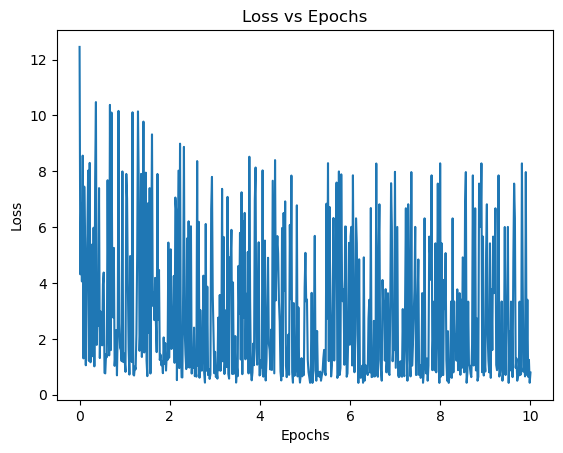

In [24]:
plt.plot(np.linspace(0,num_epochs,len(losses)),losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

In [30]:
unet.load_state_dict(best_weights)
torch.save(unet, 'models/U-Net_CFD30.pt')

In [31]:
# unet = torch.load('models/U-Net_CFD30.pt')
unet.eval()

UNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (denseBlock1): DenseBlock(
    (conv1): Conv2d(64, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(80, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(96, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(112, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (norm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(128, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (norm5): BatchNorm2d(16, eps=1e-05, m

# Testing

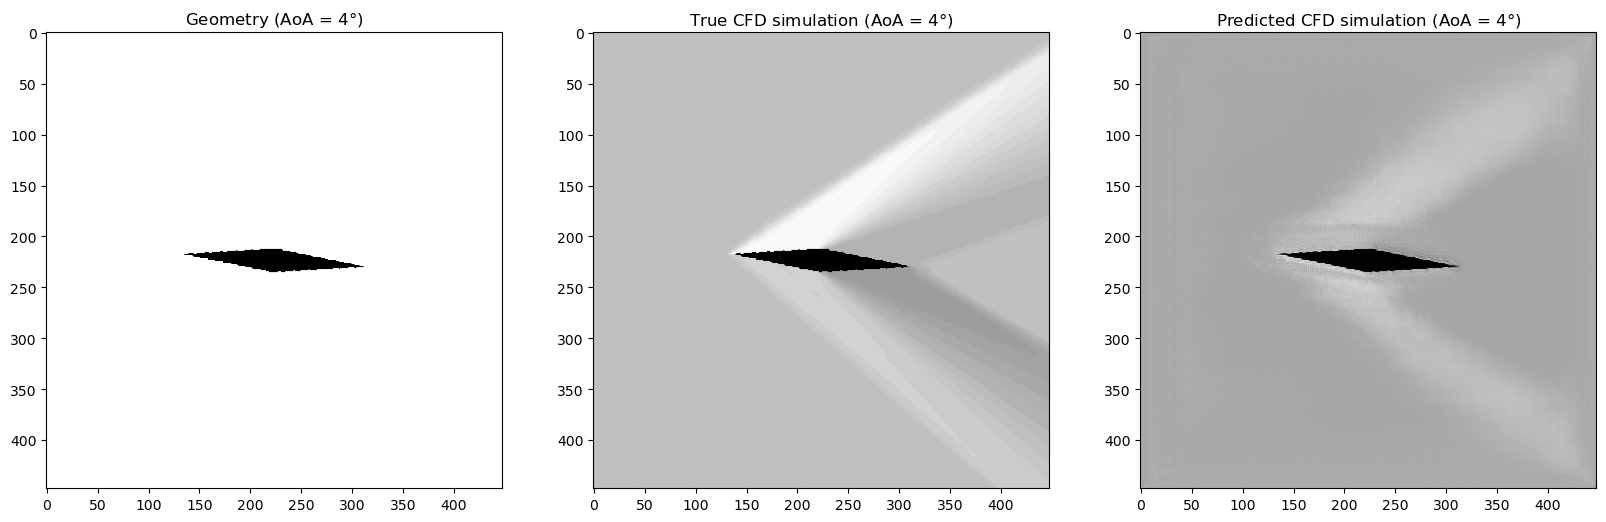

In [32]:
with torch.no_grad():
    image, mask, AoA = next(iter(train_loader))
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    image = image.to('cpu')
    image_show(image[0], mask[0], AoA[0], pred[0])

In [33]:
loss = 0
with torch.no_grad():
    for image, mask, _ in train_loader:
        image = image.to(device)
        mask = mask.to('cpu')
        pred = unet(image).cpu()
        loss += criterion(pred, mask)
    print(f'Pixel-wise loss = {loss/len(train_loader):.4f}')

Pixel-wise loss = 2.7824


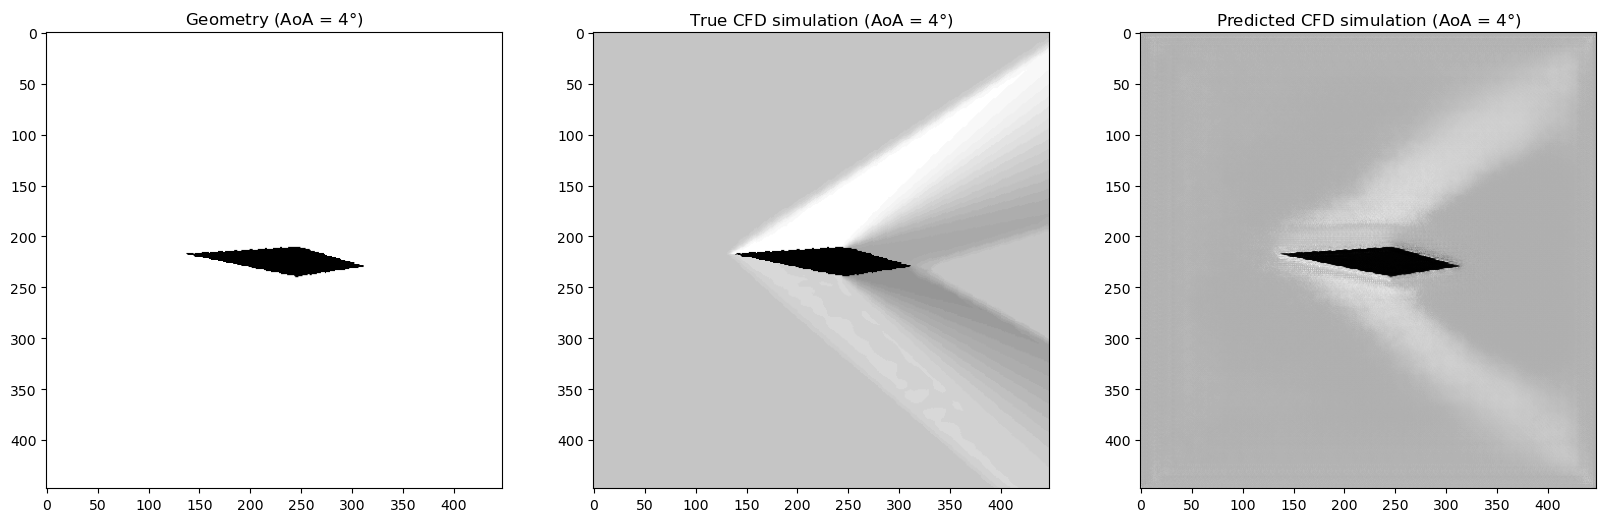

In [34]:
with torch.no_grad():
    image, mask, AoA = next(iter(val_loader))
    image = image.to(device)
    mask = mask.to('cpu')
    pred = unet(image).cpu()
    image = image.to('cpu')
    image_show(image[0], mask[0], AoA[0], pred[0])

In [35]:
loss = 0
with torch.no_grad():
    for image, mask, _ in val_loader:
        image = image.to(device)
        mask = mask.to('cpu')
        pred = unet(image).cpu()
        loss += criterion(pred, mask)
    print(f'Pixel-wise Loss = {loss/len(val_loader):.4f}')

Pixel-wise Loss = 2.1173
